In [1]:
import numpy as np 
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import redshift_connector
#https://www.kaggle.com/code/chaitanyakumar12/analysing-and-forecasting-with-arima-and-prophet

In [4]:
conn = redshift_connector.connect(
     host='redshift-cluster-1.cibczfddbdrt.us-east-1.redshift.amazonaws.com',
     database='dev',
     port=5439,
     user='awsuser',
     password='61A8!j(5Wq'
  )

cursor = conn.cursor()
df_dados = pd.DataFrame(cursor.execute("select data, local, total_casos, total_vacinacao, diaria_vacinacao, diaria_por_m_vacinacao, pessoas_total_vacinadas, mortes_novas, total_mortes, diaria_casos from covid.total_owid;"))
conn.close()

In [5]:
#df_dados.info()
df_dados.columns = ['data_casos', 'local_casos', 'total_casos', 'total_vacinacao', 'diaria_vacinacao', 'diara_por_m_vacinacao', 'pessoas_total_vacinadas', 'mortes_novas', 'total_mortes' , 'diaria_casos'     ]
#df_dados.loc[df_dados['local_casos'] == 'Brazil'].head(100)
#df_dados.head(30)

In [6]:
data = df_dados[['data_casos',
           #'local_casos',
           #'total_casos',
           #'pessoas_total_vacinadas',
           #'total_vacinacao',
           #'total_mortes',
           'diaria_vacinacao',
           'mortes_novas'
          ]].loc[df_dados['local_casos'] == 'Brazil']
#data['pessoas_total_vacinadas'] = data.pessoas_total_vacinadas.fillna(0)
#data['total_mortes'] = data.total_mortes.fillna(0)
#data['total_vacinacao'] = data.total_vacinacao.fillna(0)
data['diaria_vacinacao'] = data.diaria_vacinacao.fillna(0)
data['mortes_novas'] = data.mortes_novas.fillna(0)
data['Date'] = pd.to_datetime(data['data_casos'])
data = data.set_index(['Date'])
data.drop('data_casos', inplace=True, axis=1) 
data.head(20)


,diaria_vacinacao,mortes_novas
Date,,
2020-02-27,0,0
2020-02-28,0,0
2020-02-29,0,0
2020-03-01,0,0
2020-03-02,0,0
2020-03-03,0,0
2020-03-04,0,0
2020-03-05,0,0
2020-03-06,0,0


In [22]:
train = data.iloc[:int(len(data) * 0.85)]
test = data.iloc[int(len(data) * 0.85):]

#test['Date'] = pd.to_datetime(test['data_casos'])
#train['Date'] = pd.to_datetime(train['data_casos'])
#train = train.set_index(['Date'])
#test = test.set_index(['Date'])

#train.drop('data_casos', inplace=True, axis=1) 
#test.drop('data_casos', inplace=True, axis=1)


#train.index = train.index.to_period('M')
#test.index = test.index.to_period('M')



,diaria_vacinacao,mortes_novas
Date,,
2020-02-27,0,0
2020-02-28,0,0
2020-02-29,0,0
2020-03-01,0,0
2020-03-02,0,0
...,...,...
2022-11-18,46532,62
2022-11-19,46293,71
2022-11-20,46019,72


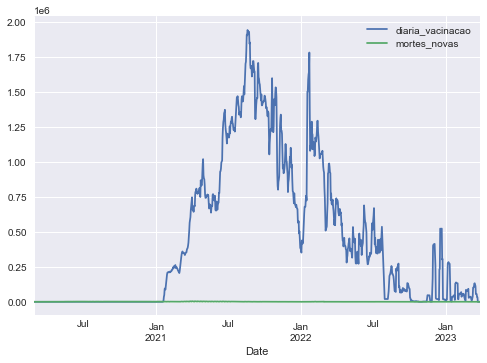

In [10]:
#train['mortes_novas'].resample(rule='M').mean().plot(figsize=(25,5))
#train['mortes_novas'].resample(rule='Q').mean().plot(figsize=(25,5))
#data['mortes_novas'].resample(rule='M').mean().plot(figsize=(25,5))
df_day=data.resample('D').sum()
df_day.plot()
df_day.head(1000)

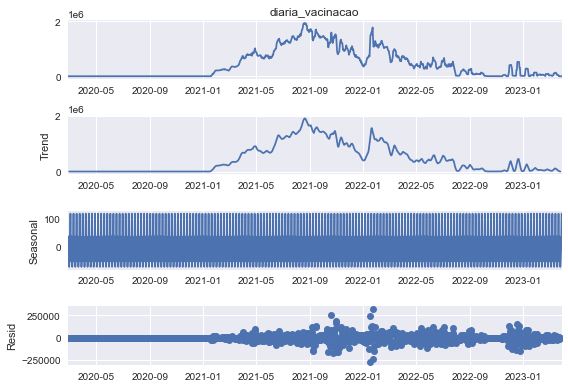

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_day['diaria_vacinacao'])
result.plot()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.Rolling.mean(timeseries, window=24)
    rolmean = timeseries.rolling(12).mean()
    #rolstd = pd.Rolling.std(timeseries, window=24)
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
              dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

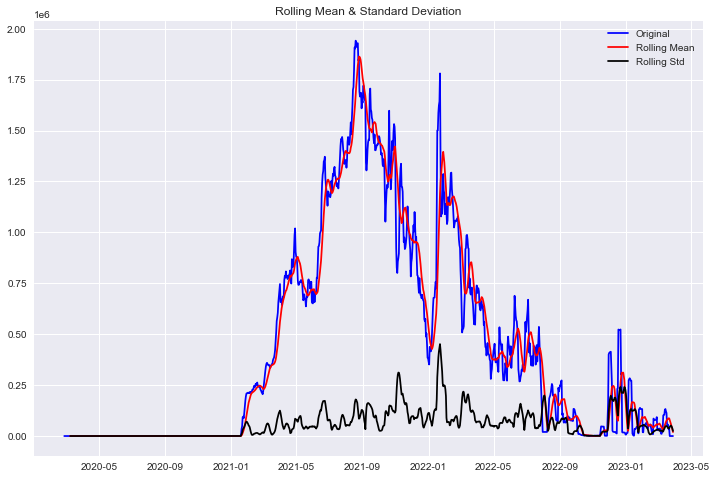

Test Statistic                   -1.340821
p-value                           0.610296
#Lags Used                       22.000000
Number of Observations Used    1104.000000
Critical Value (1%)              -3.436287
Critical Value (5%)              -2.864162
Critical Value (10%)             -2.568166
dtype: float64


In [12]:
test_stationarity(df_day['diaria_vacinacao'])

c:\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


            diaria_vacinacao  mortes_novas
Date                                      
2020-02-27              -inf          -inf
2020-02-28              -inf          -inf
2020-02-29              -inf          -inf
2020-03-01              -inf          -inf
2020-03-02              -inf          -inf
...                      ...           ...
2023-03-25              -inf          -inf
2023-03-26              -inf          -inf
2023-03-27              -inf          -inf
2023-03-28              -inf          -inf
2023-03-29              -inf          -inf

[1127 rows x 2 columns]


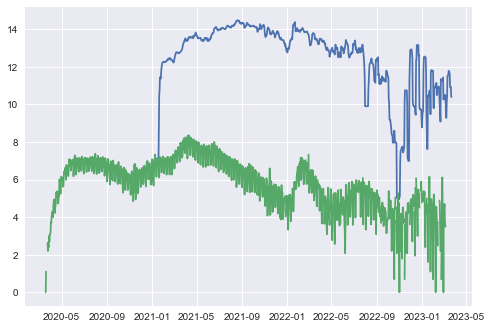

In [14]:
import numpy as np
log_df = np.log(df_day)
plt.plot(log_df)
print(log_df)

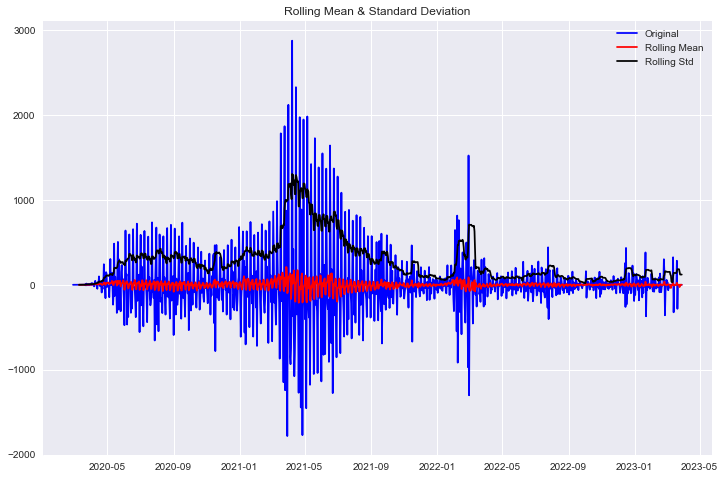

Test Statistic                   -4.801685
p-value                           0.000054
#Lags Used                       22.000000
Number of Observations Used    1103.000000
Critical Value (1%)              -3.436293
Critical Value (5%)              -2.864164
Critical Value (10%)             -2.568167
dtype: float64


In [15]:
df_day['diff1']=df_day['mortes_novas']-df_day['mortes_novas'].shift(1)
test_stationarity(df_day['diff1'].dropna())

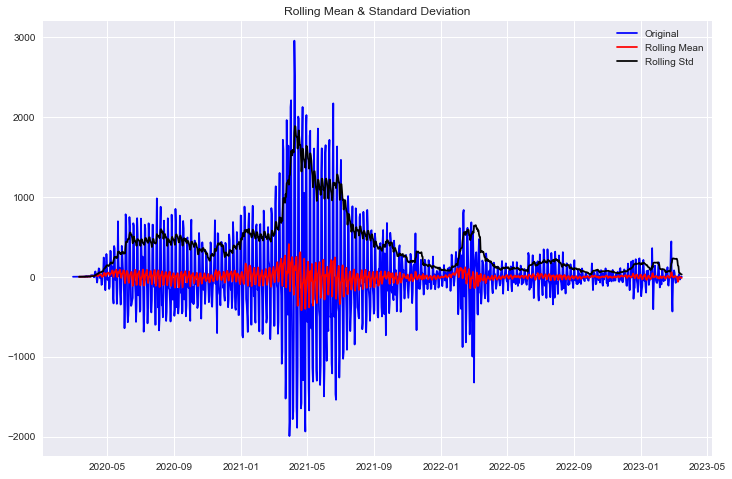

Test Statistic                   -4.497293
p-value                           0.000199
#Lags Used                       22.000000
Number of Observations Used    1089.000000
Critical Value (1%)              -3.436369
Critical Value (5%)              -2.864198
Critical Value (10%)             -2.568185
dtype: float64


In [37]:
df_day['diff2']=df_day['mortes_novas']-df_day['mortes_novas'].shift(2)
test_stationarity(df_day['diff2'].dropna())

In [41]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [42]:
#encontrando o melhor modelo para aplicar. O menor número é o melhor. (5,1,2)
auto_arima_model=auto_arima(df_day['mortes_novas'],trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15574.178, Time=2.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16291.389, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16291.714, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16176.068, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16289.389, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15901.137, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15830.192, Time=1.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15565.263, Time=2.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15806.460, Time=1.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=15355.115, Time=4.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15640.879, Time=2.50 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=15039.787, Time=4.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=15252.007, Time=2.50 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=15049.410, Time=4.77 sec
 ARIMA(4,1,3)(0,0,0

In [43]:
arima_model_202 = ARIMA(df_day['mortes_novas'].dropna(), order=(5,1,2)).fit()

c:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
arima_model_202.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           mortes_novas   No. Observations:                 1114
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -7510.886
Date:                Fri, 24 Mar 2023   AIC                          15037.772
Time:                        15:38:50   BIC                          15077.890
Sample:                    02-27-2020   HQIC                         15052.940
                         - 03-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1358      0.014      9.980      0.000       0.109       0.162
ar.L2         -0.7210      0.010    -69.395      0.000      -0.741      -0.701
ar.L3         -0.3095      0.015    -21.021      0.000      -0.338      -0.281
ar.L4         -0.3535      0.010    -34.065      0.000      -0.374      -0.333
ar.L5         -0.5751      0.013    -45.299      0.000      -0.600      -0.550
ma.L1         -0.8504      0.015    -58.509      0.000      -0.879      -0.822
ma.L2          0.5663      0.013     44.972      0.000       0.542       0.591
sigma2       3.82e+04    645.010     59.226      0.000    3.69e+04    3.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):              5563.92
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
#df_day.head(5000)

start = df_day.index.get_loc('2020-02-27')
end = df_day.index.get_loc('2023-03-16')
print(start,'to',end)

0 to 1113


In [51]:
predict_1= arima_model_202.predict(start=start+1 ,end=end+1, dynamic= False)

In [52]:
#180 adiante, incrementando a prediçao , ou seja, o futuro previsto
pred_future_10101=arima_model_202.predict(start=len(df_day)+1,end=len(df_day)+(180),dynamic=False)
print("The length of pred_future values :",len(pred_future_10101))

The length of pred_future values : 180


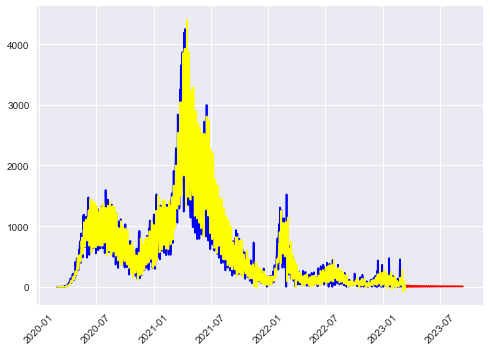

In [54]:
plt.plot(df_day['mortes_novas'],color='blue')
plt.plot(predict_1,color='yellow')
plt.plot(pred_future_10101,color='red')
plt.xticks(rotation=45)
plt.show()